### Import Libraries

In [ ]:

import sys
import numpy as np
import matplotlib.pyplot as plt
import shutil as sh 
import pandas as pd
import cv2
import os
from PIL import Image
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# using pretrained models
import torchvision.models as models
# import torchmetrics
import torchsummary
# import torchinfo

In [ ]:
import os

os.getcwd()

'/Users/meme/Documents/ANN FINAL PROJECT'

DATA PREPROCESSING

In [31]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv("data/train_solution_bounding_boxes (1).csv")

# change column name
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

# preprocess the data for yolo object detection
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['status'] = 1

# scale the data
df['x_center'] = df['x_center'] / img_w
df['w'] = df['w'] / img_w
df['y_center'] = df['y_center'] / img_h
df['h'] = df['h'] / img_h

df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes,status
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0,1
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0,1
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0,1
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0,1
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0,1


In [32]:
if not os.path.exists(os.path.join('mydata', 'images')):
    os.makedirs(os.path.join('mydata', 'images'))

if not os.path.exists(os.path.join('mydata', 'labels')):
    os.makedirs(os.path.join('mydata', 'labels'))

for idx, data in df.groupby('image_id'):
    row = data[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
    row = row.astype(str) # ['0.0', '0.45043415340236687', '0.539816602368421','0.06874095502958583', '0.09523809526315791']
    
    with open('mydata/labels/{}.txt'.format(idx), 'w+') as f:
        for i in range(len(row)):
            text = ' '.join(row[i]) #0.0 0.45043415340236687 0.539816602368421 0.06874095502958583 0.09523809526315791
            f.write(text)
            f.write('\n')

    sh.copy(
      'data/training_images/{}.jpg'.format(idx),
      'mydata/images/{}.jpg'.format(idx)
    )

In [33]:
with open('data/data.yaml', 'w+') as f:
    f.write('path: ../mydata\n')
    f.write('train: images\n')
    f.write('val: images\n\n')
    f.write('names:\n')
    f.write('  0: car')

YOLOv8 Algorithm

In [ ]:
from ultralytics import YOLO
import os 

model = YOLO('yolov8s.pt', task= 'detect')
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model.to(device)

root_dir = os.getcwd()

data_path = r"mydata\data.yaml"
data_path = os.path.join(root_dir, data_path)

model.train(data = data_path, epochs = 30, imgsz = 676, batch = 16)


Ultralytics YOLOv8.2.6 🚀 Python-3.12.1 torch-2.2.2 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/meme/Documents/ANN FINAL PROJECT/mydata/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=676, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Model summary: 225 layers, 11135987 parameters, 11135971 gradients

Transferred 349/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train5', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]


train: Scanning /Users/meme/Documents/ANN FINAL PROJECT/mydata/labels... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<00:00, 1612.40it/s]

train: New cache created: /Users/meme/Documents/ANN FINAL PROJECT/mydata/labels.cache



val: Scanning /Users/meme/Documents/ANN FINAL PROJECT/mydata/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]

Model

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO

from ultralytics.utils.checks import check_imshow
from ultralytics.utils.plotting import Annotator, colors

from collections import defaultdict

track_history = defaultdict(lambda: [])
model = YOLO("yolov8n.pt")
names = model.model.names

img="/Users/meme/Documents/ANN FINAL PROJECT/Experiment/mydata/images/vid_4_12480.jpg"

from PIL import Image
img_path = img
image = Image.open(img_path)
img_array = np.array(image)
image_dtype = img_array.dtype
print(f'Image data type" {image_dtype}')

Image data type" uint8


In [66]:
import matplotlib.pyplot as plt

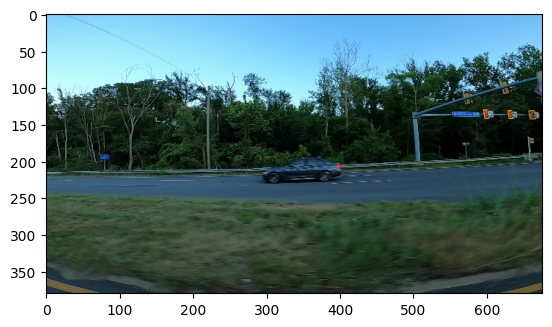

In [20]:
plt.imshow(img_array)

In [21]:
results = model.predict(img_array, conf=0.5)

for result in results:
    boxes = result.boxes

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


0: 384x640 1 car, 310.0ms
Speed: 15.2ms preprocess, 310.0ms inference, 1433.6ms postprocess per image at shape (1, 3, 384, 640)


In [22]:
class_names = model.names
class_names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [24]:
import matplotlib.patches as patches

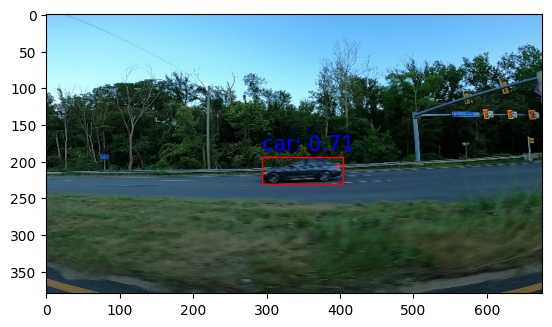

In [25]:
# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img_array)

# Iterate over the boxes and annotations
for box, conf, class_idx in zip(boxes.xyxy.cpu(), boxes.conf.cpu(), boxes.cls.cpu()):
    # Get the class index
    class_index = int(class_idx)

    # Get the class name
    class_name = class_names[class_index]

    # Get the box coordinates
    x1, y1, x2, y2 = box[:4]

    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the axes
    ax.add_patch(rect)

    # Add the label and confidence score
    label = f"{class_name}: {conf:.2f}"
    ax.text(x1, y1 - 10, label, fontsize=15, color='b')

# Show the plot
plt.show()

In [26]:
data_train='/Users/meme/Documents/ANN FINAL PROJECT/Experiment/Data/training_images'
train_csv = '/Users/meme/Documents/ANN FINAL PROJECT/Experiment/Data/train_solution_bounding_boxes (1).csv'
test_data = '/Users/meme/Documents/ANN FINAL PROJECT/Experiment/Data/testing_images'

In [73]:
model.train(data='/Users/meme/Documents/ANN FINAL PROJECT/Experiment/mydata/data.yaml', epochs=50, patience=5, batch=16,
           lr0=0.001, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.8 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.6 🚀 Python-3.12.1 torch-2.2.2 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=/Users/meme/Documents/ANN FINAL PROJECT/runs/detect/train6/weights/best.pt, data=/Users/meme/Documents/ANN FINAL PROJECT/mydata/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning /Users/meme/Documents/ANN FINAL PROJECT/mydata/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
val: Scanning /Users/meme/Documents/ANN FINAL PROJECT/mydata/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]

Plotting labels to runs/detect/train7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.131     0.7193      1.016         11        640: 100%|██████████| 23/23 [02:59<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:28<00:00,  2.40s/it]

                   all        355        559      0.978      0.969      0.991      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.148     0.6881      1.026         10        640: 100%|██████████| 23/23 [03:06<00:00,  8.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:31<00:00,  2.60s/it]

                   all        355        559      0.965      0.981      0.991      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.148     0.6893      1.019          8        640: 100%|██████████| 23/23 [03:07<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:30<00:00,  2.57s/it]

                   all        355        559      0.982      0.978      0.993      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.159      0.693      1.036         11        640: 100%|██████████| 23/23 [03:14<00:00,  8.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:30<00:00,  2.52s/it]

                   all        355        559      0.975      0.975      0.992      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.166     0.6863      1.027          7        640: 100%|██████████| 23/23 [03:14<00:00,  8.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]

                   all        355        559      0.978      0.957       0.99      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.189      0.693      1.051         12        640: 100%|██████████| 23/23 [03:23<00:00,  8.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]

                   all        355        559      0.976      0.955      0.991      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.165     0.6604      1.054         10        640: 100%|██████████| 23/23 [03:27<00:00,  9.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:31<00:00,  2.67s/it]

                   all        355        559      0.975      0.979      0.992      0.684
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.440 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.2.6 🚀 Python-3.12.1 torch-2.2.2 CPU (Apple M1)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:30<00:00,  2.53s/it]


                   all        355        559      0.965      0.981      0.991      0.692
Speed: 0.7ms preprocess, 77.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x1a96c0b60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    

In [74]:
path_best_weights="/Users/meme/Documents/ANN FINAL PROJECT/Experiment/runs/detect/train6/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val() 

Ultralytics YOLOv8.2.6 🚀 Python-3.12.1 torch-2.2.2 CPU (Apple M1)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/meme/Documents/ANN FINAL PROJECT/mydata/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:26<00:00,  1.16s/it]


                   all        355        559      0.975      0.987      0.993      0.708
Speed: 0.9ms preprocess, 67.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val3


In [76]:
print(f'mean average precision @ .50: {metrics.box.map50}')

mean average precision @ .50: 0.9926103662119635


In [77]:
import torch
with torch.no_grad():
    results = model.predict(source = test_data, conf=0.5, iou=0.75)


image 1/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 154.7ms
image 2/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 122.3ms
image 3/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 113.6ms
image 4/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 115.3ms
image 5/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 110.2ms
image 6/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 113.9ms
image 7/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 115.3ms
image 8/175 /Users/meme/Documents/ANN FINAL PROJECT/Data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 111.2ms
image 9/175 /Users/meme

TEST MODEL

In [53]:
prediction_dir = '/Users/meme/Documents/ANN FINAL PROJECT/mydata'

In [54]:
import os

In [78]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [79]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

In [80]:
import pandas as pd

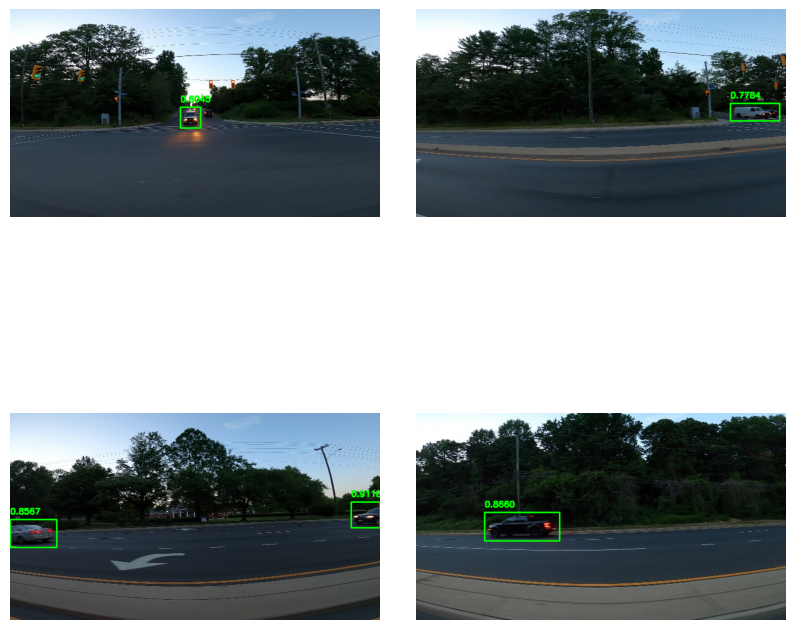

In [88]:
fig,axes=plt.subplots(2,2,figsize=(10,10))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,4)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_data,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])
    
plt.savefig("car.png")

ADD 2 CONVOLUTIONAL NEURAL NETWORK LAYERS TO YOLOv8 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from data_setup import licenceplate

In [ ]:

os.getcwd()

file_url = r"/Users/meme/Documents/ANN FINAL PROJECT/Data"


data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

# Create a dataset object with the file path and transformation function
train_dataset = licenceplate(root_dir=file_url, split='train', transform = None)
valid_dataset = licenceplate(root_dir=file_url, split='valid', transform = None)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=15, shuffle=True)


class YOLO("yolov8n.pt")(nn.Module):
    def __init__(self):
        super(YOLO("yolov8n.pt"), self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 

# Example usage
model = YOLO("yolov8n.pt")
input_tensor = torch.randn(1, 3, 416, 416)  #input shape
output_tensor = model(input_tensor)
print(output_tensor.shape) 

In [ ]:
model.train(data='/Users/meme/Documents/ANN FINAL PROJECT/mydata/data.yaml', epochs=4, patience=5, batch=16,
           lr0=0.001, imgsz=640)